In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
# Parameters
FPS = 5  # Frames per second for extraction
ROOT_DIR = "/content/drive/MyDrive/research"
FRAME_DIR = os.path.join('extracted_frames_5FPS')
DATA_DIR = os.path.join(ROOT_DIR, 'data')

# Create data generators
BATCH_SIZE = 1
MAX_FRAMES = 500


In [3]:
import os
import cv2

def extract_frames(video_path, target_fps):
    video = cv2.VideoCapture(video_path)
    original_fps = int(video.get(cv2.CAP_PROP_FPS))
    frame_interval = original_fps // target_fps
    count = 0
    success, image = video.read()
    frames = []
    while success:
        if count % frame_interval == 0:
            frames.append(image)
        success, image = video.read()
        count += 1
    video.release()
    return frames

def save_frames(frames, folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    for i, frame in enumerate(frames):
        frame_path = os.path.join(folder_path, f"frame_{i}.jpg")
        cv2.imwrite(frame_path, frame)

def process_directory(directory_path, output_path, target_fps=FPS):
    for category in ['shoplifting videos', 'normal videos']:
        category_path = os.path.join(directory_path, category)
        video_files = [os.path.join(category_path, f) for f in os.listdir(category_path)]

        for video_file in video_files:
            frames = extract_frames(video_file, target_fps)
            video_base_name = os.path.splitext(os.path.basename(video_file))[0]
            frame_folder = os.path.join(output_path, category, video_base_name)
            save_frames(frames, frame_folder)

if not os.path.exists(FRAME_DIR):
    for subset in ['train', 'test', 'validation']:
        process_directory(os.path.join(DATA_DIR, subset), os.path.join(FRAME_DIR, subset), target_fps=FPS)


In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import os
import cv2
import numpy as np
from tensorflow.keras.utils import Sequence

# Load the pre-trained ResNet50 model for feature extraction
resnet50_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor = hub.KerasLayer(resnet50_url, trainable=False)

def extract_features(image, frame_size=(224, 224)):
    """Extract features from image using ResNet50."""
    image = tf.image.resize(image, frame_size)
    image = tf.expand_dims(image, axis=0)
    features = feature_extractor(image)
    return features.numpy().flatten()

class PyDataset(Sequence):
    def __init__(self, data_dir, batch_size=8, frame_size=(224, 224), max_frames=30, **kwargs):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.frame_size = frame_size
        self.max_frames = max_frames
        self.classes = ['normal videos', 'shoplifting videos']
        self.file_paths = []
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(data_dir, class_name)
            videos = [os.path.join(class_dir, video) for video in os.listdir(class_dir)]
            for video in videos:
                frames = [os.path.join(video, fname) for fname in os.listdir(video) if fname.endswith('.jpg')]
                self.file_paths.append((frames, class_idx))
        self.on_epoch_end()
        super().__init__(**kwargs)

    def __len__(self):
        return (len(self.file_paths) + self.batch_size - 1) // self.batch_size  # Ensure rounding up

    def __getitem__(self, idx):
        batch_paths = self.file_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_frames = []
        batch_labels = []
        for paths, label in batch_paths:
            frames = []
            total_frames = len(paths)
            frame_interval = max(1, total_frames // self.max_frames)  # Downsample based on max_frames
            for i in range(0, total_frames, frame_interval):
                if len(frames) >= self.max_frames:
                    break
                frame = cv2.imread(paths[i])
                frame = cv2.resize(frame, self.frame_size)
                frame = tf.convert_to_tensor(frame, dtype=tf.float32) / 255.0  # Normalize to [0, 1]
                features = extract_features(frame, self.frame_size)
                frames.append(features)
            if len(frames) < self.max_frames:
                frames.extend([np.zeros(2048)] * (self.max_frames - len(frames)))  # Padding with zeros
            batch_frames.append(frames)
            batch_labels.append(label)

        batch_frames = np.array(batch_frames)
        batch_labels = np.array(batch_labels)

        return batch_frames, batch_labels

    def on_epoch_end(self):
        np.random.shuffle(self.file_paths)


train_gen = PyDataset(os.path.join(FRAME_DIR, 'train'), batch_size=BATCH_SIZE, max_frames=MAX_FRAMES)
val_gen = PyDataset(os.path.join(FRAME_DIR, 'validation'), batch_size=BATCH_SIZE, max_frames=MAX_FRAMES)
test_gen = PyDataset(os.path.join(FRAME_DIR, 'test'), batch_size=BATCH_SIZE, max_frames=MAX_FRAMES)


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, Masking
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC

def create_rnn_model(input_shape):
    inputs = Input(shape=input_shape)
    masked = Masking(mask_value=0.)(inputs)  # Mask padding
    time_distributed = TimeDistributed(Dense(128, activation='relu'))(masked)
    lstm = LSTM(512, return_sequences=False)(time_distributed)
    outputs = Dense(1, activation='sigmoid')(lstm)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall(), AUC()])
    return model

# Create and train the RNN model
input_shape = (MAX_FRAMES, 2048)  # MAX_FRAMES for sequence length, 2048 for feature vector size from ResNet50
rnn_model = create_rnn_model(input_shape)
rnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 2048)]       0         
                                                                 
 masking (Masking)           (None, 500, 2048)         0         
                                                                 
 time_distributed (TimeDist  (None, 500, 128)          262272    
 ributed)                                                        
                                                                 
 lstm (LSTM)                 (None, 512)               1312768   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1575553 (6.01 MB)
Trainable params: 1575553 (6.01 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________

In [6]:
checkpoint_cb = ModelCheckpoint(os.path.join(ROOT_DIR, 'models', 'model_b_2_5FPS.keras' ), save_best_only=True)

# history = rnn_model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=[checkpoint_cb])


# Specify that you want to use the GPU
if tf.config.list_physical_devices('GPU'):
    with tf.device('GPU:0'):
        history = rnn_model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=[checkpoint_cb])
else:
    print("No GPU available, using CPU.")

Epoch 1/20
84/84 [==============================] - 176s 2s/step - loss: 0.6861 - accuracy: 0.6905 - precision: 0.6905 - recall: 0.6905 - auc: 0.7358 - val_loss: 0.4846 - val_accuracy: 0.7778 - val_precision: 1.0000 - val_recall: 0.5556 - val_auc: 0.8765
Epoch 2/20
84/84 [==============================] - 169s 2s/step - loss: 0.2164 - accuracy: 0.9286 - precision: 0.9500 - recall: 0.9048 - auc: 0.9725 - val_loss: 0.7210 - val_accuracy: 0.7778 - val_precision: 0.7778 - val_recall: 0.7778 - val_auc: 0.8704
Epoch 3/20
84/84 [==============================] - 168s 2s/step - loss: 0.1827 - accuracy: 0.9405 - precision: 0.9302 - recall: 0.9524 - auc: 0.9694 - val_loss: 0.7542 - val_accuracy: 0.7222 - val_precision: 0.7500 - val_recall: 0.6667 - val_auc: 0.8148
Epoch 4/20
84/84 [==============================] - 169s 2s/step - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.3376 - val_accuracy: 0.6667 - val_precision: 0.7143 - val_recall: 0.555

In [7]:
import pickle

# Save the history
with open(os.path.join(ROOT_DIR,'models','model_b_2_5FPS.pkl'), 'wb') as file:
    pickle.dump(history.history, file)

# Load the history
with open(os.path.join(ROOT_DIR,'models','model_b_2_5FPS.pkl'), 'rb') as file:
    history = pickle.load(file)

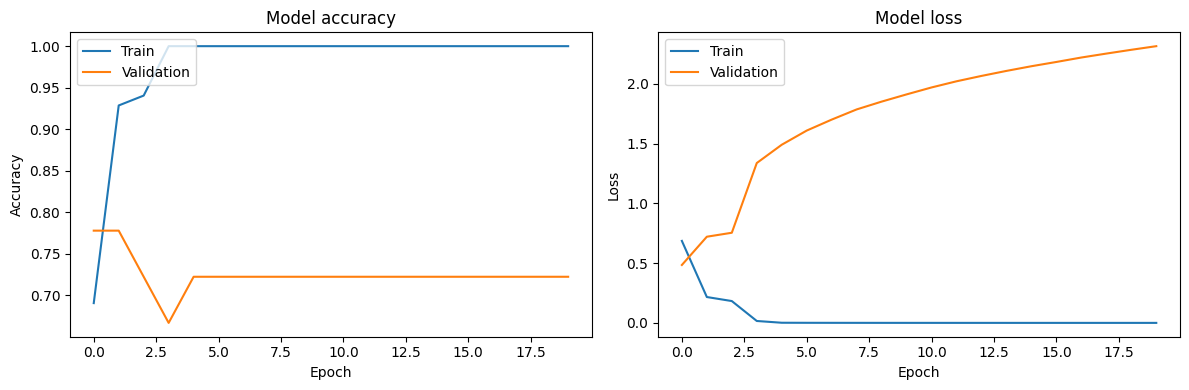

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [9]:
# Load the best model and evaluate it
rnn_model.load_weights(os.path.join(ROOT_DIR, 'models', 'model_b_2_5FPS.keras'))
loss, accuracy, precision, recall, auc_score = rnn_model.evaluate(test_gen)
print(f'Test Accuracy: {accuracy}')
print(f'Test Precision: {precision}')
print(f'Test Recall: {recall}')
print(f'Test AUC: {auc_score}')

18/18 [==============================] - 26s 1s/step - loss: 0.3904 - accuracy: 0.7778 - precision: 0.7778 - recall: 0.7778 - auc: 0.8951
Test Accuracy: 0.7777777910232544
Test Precision: 0.7777777910232544
Test Recall: 0.7777777910232544
Test AUC: 0.8950617909431458


Processing batch 1/18
1/1 [==============================] - 1s 1s/step
Batch Frames Shape: (1, 500, 2048)
Batch Labels Shape: (1,)
Predictions Shape: (1, 1)
Rounded Predictions: [1]
True Labels: [1]
Min Prediction: 0.90994895 Max Prediction: 0.90994895
Min Label: 1 Max Label: 1
Predictions Contain NaN: False
Labels Contain NaN: False
Processing batch 2/18
1/1 [==============================] - 0s 25ms/step
Batch Frames Shape: (1, 500, 2048)
Batch Labels Shape: (1,)
Predictions Shape: (1, 1)
Rounded Predictions: [1]
True Labels: [0]
Min Prediction: 0.5077186 Max Prediction: 0.5077186
Min Label: 0 Max Label: 0
Predictions Contain NaN: False
Labels Contain NaN: False
Processing batch 3/18
1/1 [==============================] - 0s 31ms/step
Batch Frames Shape: (1, 500, 2048)
Batch Labels Shape: (1,)
Predictions Shape: (1, 1)
Rounded Predictions: [0]
True Labels: [0]
Min Prediction: 0.4000267 Max Prediction: 0.4000267
Min Label: 0 Max Label: 0
Predictions Contain NaN: False
Labels Contain 

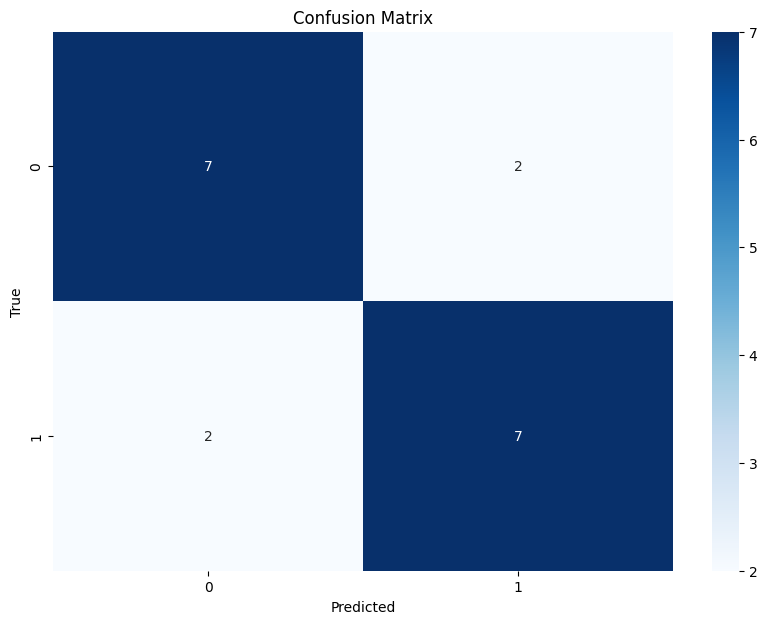

In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize lists for predictions and true labels
y_pred = []
y_true = []

# Get the number of steps in the generator
num_steps = len(test_gen)

# Iterate over the test generator batches
for i, (batch_frames, batch_labels) in enumerate(test_gen):
    if i >= num_steps:
        break
    try:
        print(f"Processing batch {i+1}/{num_steps}")
        predictions = rnn_model.predict(batch_frames)  # Disable progress bar
        # Ensure predictions are in the range [0, 1]
        predictions = np.clip(predictions, 0, 1)
        # Round predictions to get binary outputs (0 or 1)
        rounded_predictions = np.round(predictions).astype(int).flatten()

        # Debugging Statements
        print("Batch Frames Shape:", batch_frames.shape)
        print("Batch Labels Shape:", batch_labels.shape)
        print("Predictions Shape:", predictions.shape)
        print("Rounded Predictions:", rounded_predictions)
        print("True Labels:", batch_labels.flatten())
        print("Min Prediction:", np.min(predictions), "Max Prediction:", np.max(predictions))
        print("Min Label:", np.min(batch_labels), "Max Label:", np.max(batch_labels))
        print("Predictions Contain NaN:", np.any(np.isnan(predictions)))
        print("Labels Contain NaN:", np.any(np.isnan(batch_labels)))

        y_pred.extend(rounded_predictions)
        y_true.extend(batch_labels.flatten())
    except Exception as e:
        print(f"Error processing batch {i+1}: {e}")
        break

# Generate classification report and confusion matrix
try:
    print("Unique predictions:", np.unique(y_pred))
    print("Unique true labels:", np.unique(y_true))
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))
except Exception as e:
    print(f"Error in classification_report: {e}")

try:
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
except Exception as e:
    print(f"Error in confusion_matrix plotting: {e}")


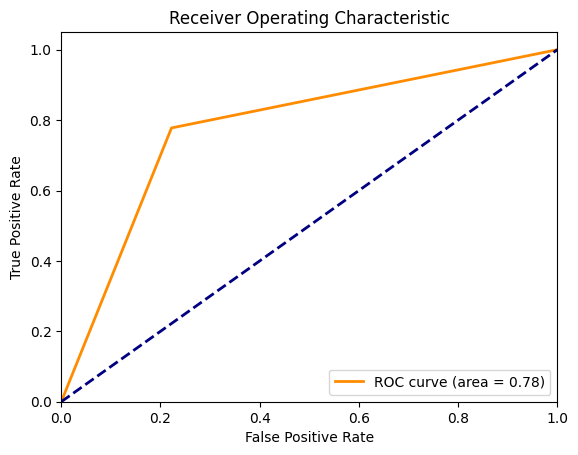

In [11]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [12]:
def load_and_preprocess_video(video_path, frame_size=(224, 224), max_frames=30, target_fps=5):
    cap = cv2.VideoCapture(video_path)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(frame_rate // target_fps)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if len(frames) % frame_interval == 0:
            frame = cv2.resize(frame, frame_size)
            frame = tf.convert_to_tensor(frame, dtype=tf.float32) / 255.0  # Normalize to [0, 1]
            features = extract_features(frame, frame_size)
            frames.append(features)
        if len(frames) >= max_frames:
            break

    cap.release()
    if len(frames) < max_frames:
        frames.extend([np.zeros(2048)] * (max_frames - len(frames)))  # Padding with zeros

    return np.array(frames)

In [13]:
video_paths = os.listdir(os.path.join(DATA_DIR,'test', 'normal videos'))

for video in video_paths:
    full_video_path = os.path.join(DATA_DIR, 'test', 'normal videos', video)
    video_frames = load_and_preprocess_video(full_video_path)
    video_frames = np.expand_dims(video_frames, axis=0)  # Add batch dimension

    # Make predictions on the video frames
    predictions = rnn_model.predict(video_frames)

    # Ensure predictions are in the range [0, 1]
    predictions = np.clip(predictions, 0, 1)
    # Round predictions to get binary outputs (0 or 1)
    rounded_predictions = np.round(predictions).astype(int).flatten()

    # binary classification: 0 = normal video, 1 = shoplifting video
    if rounded_predictions.mean() > 0.5:
        print("The video is classified as a shoplifting video.")
    else:
        print("The video is classified as a normal video.")

1/1 [==============================] - 1s 1s/step
The video is classified as a normal video.
1/1 [==============================] - 0s 21ms/step
The video is classified as a normal video.
1/1 [==============================] - 0s 21ms/step
The video is classified as a normal video.
1/1 [==============================] - 0s 21ms/step
The video is classified as a normal video.
1/1 [==============================] - 0s 21ms/step
The video is classified as a shoplifting video.
1/1 [==============================] - 0s 21ms/step
The video is classified as a shoplifting video.
1/1 [==============================] - 0s 20ms/step
The video is classified as a normal video.
1/1 [==============================] - 0s 21ms/step
The video is classified as a normal video.
1/1 [==============================] - 0s 21ms/step
The video is classified as a normal video.


In [14]:
video_paths = os.listdir(os.path.join(DATA_DIR, 'test', 'shoplifting videos'))
for video in video_paths:
    full_video_path = os.path.join(DATA_DIR, 'test', 'shoplifting videos', video)
    video_frames = load_and_preprocess_video(full_video_path)
    video_frames = np.expand_dims(video_frames, axis=0)  # Add batch dimension

    # Make predictions on the video frames
    predictions = rnn_model.predict(video_frames)

    # Ensure predictions are in the range [0, 1]
    predictions = np.clip(predictions, 0, 1)
    # Round predictions to get binary outputs (0 or 1)
    rounded_predictions = np.round(predictions).astype(int).flatten()

    # binary classification: 0 = normal video, 1 = shoplifting video
    if rounded_predictions.mean() > 0.5:
        print("The video is classified as a shoplifting video.")
    else:
        print("The video is classified as a normal video.")

1/1 [==============================] - 0s 21ms/step
The video is classified as a shoplifting video.
1/1 [==============================] - 0s 21ms/step
The video is classified as a shoplifting video.
1/1 [==============================] - 0s 21ms/step
The video is classified as a shoplifting video.
1/1 [==============================] - 0s 20ms/step
The video is classified as a normal video.
1/1 [==============================] - 0s 20ms/step
The video is classified as a normal video.
1/1 [==============================] - 0s 21ms/step
The video is classified as a normal video.
1/1 [==============================] - 0s 21ms/step
The video is classified as a shoplifting video.
1/1 [==============================] - 0s 21ms/step
The video is classified as a shoplifting video.
1/1 [==============================] - 0s 21ms/step
The video is classified as a shoplifting video.
